# 梯度消失、梯度爆炸以及Kaggle房价预测

1. 梯度消失和梯度爆炸
2. 考虑到环境因素的其他问题
3. Kaggle房价预测

# 梯度消失和梯度爆炸

深度模型有关数值稳定性的典型问题是消失（vanishing）和爆炸（explosion）。

**当神经网络的层数较多时，模型的数值稳定性容易变差。**

假设一个层数为$L$的多层感知机的第$l$层$\boldsymbol{H}^{(l)}$的权重参数为$\boldsymbol{W}^{(l)}$，输出层$\boldsymbol{H}^{(L)}$的权重参数为$\boldsymbol{W}^{(L)}$。为了便于讨论，不考虑偏差参数，且设所有隐藏层的激活函数为恒等映射（identity mapping）$\phi(x) = x$。给定输入$\boldsymbol{X}$，多层感知机的第$l$层的输出$\boldsymbol{H}^{(l)} = \boldsymbol{X} \boldsymbol{W}^{(1)} \boldsymbol{W}^{(2)} \ldots \boldsymbol{W}^{(l)}$。此时，如果层数$l$较大，$\boldsymbol{H}^{(l)}$的计算可能会出现衰减或爆炸。举个例子，假设输入和所有层的权重参数都是标量，如权重参数为0.2和5，多层感知机的第30层输出为输入$\boldsymbol{X}$分别与$0.2^{30} \approx 1 \times 10^{-21}$（消失）和$5^{30} \approx 9 \times 10^{20}$（爆炸）的乘积。当层数较多时，梯度的计算也容易出现消失或爆炸。

# 随机初始化模型参数

在神经网络中，通常需要随机初始化模型参数。下面我们来解释这样做的原因。

回顾多层感知机一节描述的多层感知机。为了方便解释，假设输出层只保留一个输出单元$o_1$（删去$o_2$和$o_3$以及指向它们的箭头），且隐藏层使用相同的激活函数。如果将每个隐藏单元的参数都初始化为相等的值，那么在正向传播时每个隐藏单元将根据相同的输入计算出相同的值，并传递至输出层。在反向传播中，每个隐藏单元的参数梯度值相等。因此，这些参数在使用基于梯度的优化算法迭代后值依然相等。之后的迭代也是如此。在这种情况下，无论隐藏单元有多少，隐藏层本质上只有1个隐藏单元在发挥作用。因此，正如在前面的实验中所做的那样，我们通常将神经网络的模型参数，特别是权重参数，进行随机初始化。



![Image Name](https://cdn.kesci.com/upload/image/q5jg76kloy.png?imageView2/0/w/960/h/960)



###  PyTorch的默认随机初始化

随机初始化模型参数的方法有很多。在线性回归的简洁实现中，我们使用`torch.nn.init.normal_()`使模型`net`的权重参数采用正态分布的随机初始化方式。不过，PyTorch中`nn.Module`的模块参数都采取了较为合理的初始化策略（不同类型的layer具体采样的哪一种初始化方法的可参考[源代码](https://github.com/pytorch/pytorch/tree/master/torch/nn/modules)），因此一般不用我们考虑。


### Xavier随机初始化

还有一种比较常用的随机初始化方法叫作Xavier随机初始化。
假设某全连接层的输入个数为$a$，输出个数为$b$，Xavier随机初始化将使该层中权重参数的每个元素都随机采样于均匀分布


$$
U\left(-\sqrt{\frac{6}{a+b}}, \sqrt{\frac{6}{a+b}}\right).
$$


它的设计主要考虑到，模型参数初始化后，每层输出的方差不该受该层输入个数影响，且每层梯度的方差也不该受该层输出个数影响。

# 考虑环境因素

## 协变量偏移

这里我们假设，虽然输入的分布可能随时间而改变，但是标记函数，即条件分布P（y∣x）不会改变。虽然这个问题容易理解，但在实践中也容易忽视。

想想区分猫和狗的一个例子。我们的训练数据使用的是猫和狗的真实的照片，但是在测试时，我们被要求对猫和狗的卡通图片进行分类。

|cat|cat|dog|dog|
|:---------------:|:---------------:|:---------------:|:---------------:|
|![Image Name](https://cdn.kesci.com/upload/image/q5jg8j72fl.jpg?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jg993za3.jpg?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jg9tqs4s.jpg?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jga6mnsk.jpg?imageView2/0/w/200/h/200)|

测试数据：

|cat|cat|dog|dog|
|:---------------:|:---------------:|:---------------:|:---------------:|
|![Image Name](https://cdn.kesci.com/upload/image/q5jgat5lsd.png?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jgbaoij8.png?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jgbswvbb.png?imageView2/0/w/200/h/200)|![Image Name](https://cdn.kesci.com/upload/image/q5jgc5j7zv.png?imageView2/0/w/200/h/200)
|

显然，这不太可能奏效。训练集由照片组成，而测试集只包含卡通。在一个看起来与测试集有着本质不同的数据集上进行训练，而不考虑如何适应新的情况，这是不是一个好主意。不幸的是，这是一个非常常见的陷阱。

统计学家称这种协变量变化是因为问题的根源在于特征分布的变化（即协变量的变化）。数学上，我们可以说P（x）改变了，但P（y∣x）保持不变。尽管它的有用性并不局限于此，当我们认为x导致y时，协变量移位通常是正确的假设。


## 标签偏移

    
当我们认为导致偏移的是标签P（y）上的边缘分布的变化，但类条件分布是不变的P（x∣y）时，就会出现相反的问题。当我们认为y导致x时，标签偏移是一个合理的假设。例如，通常我们希望根据其表现来预测诊断结果。在这种情况下，我们认为诊断引起的表现，即疾病引起的症状。有时标签偏移和协变量移位假设可以同时成立。例如，当真正的标签函数是确定的和不变的，那么协变量偏移将始终保持，包括如果标签偏移也保持。有趣的是，当我们期望标签偏移和协变量偏移保持时，使用来自标签偏移假设的方法通常是有利的。这是因为这些方法倾向于操作看起来像标签的对象，这（在深度学习中）与处理看起来像输入的对象（在深度学习中）相比相对容易一些。

病因（要预测的诊断结果）导致 症状（观察到的结果）。  

训练数据集，数据很少只包含流感p(y)的样本。  

而测试数据集有流感p(y)和流感q(y)，其中不变的是流感症状p(x|y)。


## 概念偏移

另一个相关的问题出现在概念转换中，即标签本身的定义发生变化的情况。这听起来很奇怪，毕竟猫就是猫。的确，猫的定义可能不会改变，但我们能不能对软饮料也这么说呢？事实证明，如果我们周游美国，按地理位置转移数据来源，我们会发现，即使是如图所示的这个简单术语的定义也会发生相当大的概念转变。


![Image Name](https://cdn.kesci.com/upload/image/q5jgd81pl3.png?imageView2/0/w/640/h/640)

$$
美国软饮料名称的概念转变 
$$
如果我们要建立一个机器翻译系统，分布P（y∣x）可能因我们的位置而异。这个问题很难发现。另一个可取之处是P（y∣x）通常只是逐渐变化。

# Kaggle 房价预测实战

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("../")
import d2lzh1981 as d2l
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.1.0


## 读取数据

In [2]:
test_data = pd.read_csv("D:\\Users\\Desktop\\haha\\data\\house_price\\test.csv")
train_data = pd.read_csv("D:\\Users\\Desktop\\haha\\data\\house_price\\train.csv")

In [3]:
train_data.shape

(1460, 81)

In [4]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [6]:
all_features.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## 预处理数据

In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [8]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [9]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

## 训练模型

In [10]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [11]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

In [13]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [14]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.239642, valid rmse 0.221485
fold 1, train rmse 0.229559, valid rmse 0.270627
fold 2, train rmse 0.231842, valid rmse 0.238379
fold 3, train rmse 0.237482, valid rmse 0.218826
fold 4, train rmse 0.230932, valid rmse 0.258711
5-fold validation: avg train rmse 0.233892, avg valid rmse 0.241606


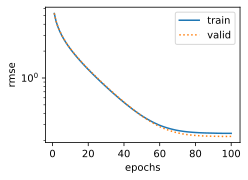

In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))